In [1]:
import os

In [2]:
# hiwgpu1 has 4 GPU ('0', '1', '2', '3'), we use '0' here
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpu = 'gpu0'

In [3]:
from preprocess_for_multi_tephi_input import *
from build_model_for_multi_tephi_input import *
from post_processing_for_multi_tephi_input import *
import simplejson as json
import joblib

In [4]:
# Set random seed
tf.random.set_seed(42)

In [5]:
start = datetime.now()
yyyymmdd = start.strftime('%Y%m%d')
HHMM = start.strftime('%H%M')

## Setting

In [6]:
feature_to_scale = ['TEMP', 'DWPT', 'Wdir', 'Wspd']#, 'depression']
feature_scaled = [x + '_scaled' for x in feature_to_scale]

In [7]:
sequence_length = 2 
img_height = 350
img_width = 250

n_layer = 90
n_feature = len(feature_scaled)

batch_size = 32

classes = [0, 1, 2] # Set to [0, 1] for binary classification
n_class = len(classes)

In [8]:
# Load the fitted scaler
scaler_filename = "./scaler/scaler_f4.save"
scaler = joblib.load(scaler_filename) 

## Directory

In [9]:
public_dir = '/home/deeplearn/public_html/tephi_350x250/tephi_png_without_background_actual' # Source of actual tephi
public_dir_ec = '/home/deeplearn/public_html/tephi_350x250/tephi_png_without_background_EC' # Source of EC tephi

target_dir = '/home/deeplearn/cslau/tfrecords' # Directory for training
ver_dir = '/home/deeplearn/cslau' # Directory for EC verification

checkpoint_dir = '/home/deeplearn/cslau/saved_model_%s_%s' % (yyyymmdd, gpu) # Directory to save the model
    
public_dir_model = '/home/deeplearn/public_html/%s_%s_model_%s' % (yyyymmdd, gpu, HHMM) # Directory to save the figures and csv

## Pre-processing

In [10]:
df_dv = get_DV_df('/home/deeplearn/cslau/199101-202109_max_min_DV.csv', n_class)

In [11]:
df_00 = get_sounding_df('tephi_interpolate_90_levels_00Z.csv')
df_12 = get_sounding_df('tephi_interpolate_90_levels_12Z.csv')

In [12]:
df_00 = remove_no_dv(df_dv, df_00)

In [13]:
df_00 = define_train_valid_test(df_00)

# Define train, valid, test for DV data
for stage in ['train', 'valid', 'test']:
    df_dv[stage] = (df_dv['date'] >= df_00[df_00[stage]]['date'].min()) & (df_dv['date'] <= df_00[df_00[stage]]['date'].max())

In [14]:
df_00, scaler = rescale_sounding_data(df_00, feature_to_scale)
df_12, _ = rescale_sounding_data(df_12, feature_to_scale, scaler=scaler)

# Save scaled sounding data as .npy to public_dir
save_all_scaled_sounding_data(df_00, public_dir, feature_scaled)
save_all_scaled_sounding_data(df_12, public_dir, feature_scaled)

'''
scaler_filename = "/home/deeplearn/cslau/scaler/scaler_f5.save"
if not os.path.exists(scaler_filename):
    joblib.dump(scaler, scaler_filename)
'''

## Generate TFRecords

In [15]:
tephi_img_list = glob.glob(public_dir + '/*.png')

tephi_date_list = [x.split('.')[0][-10:] for x in tephi_img_list]
upper_air_soundings_list = [x.replace('.png', '_scaled.npy') for x in tephi_img_list]

In [16]:
df_dv = remove_no_tephis(df_dv, tephi_date_list)

In [17]:
train_date = df_dv[df_dv['train']]['date'].values
valid_date = df_dv[df_dv['valid']]['date'].values
test_date = df_dv[df_dv['test']]['date'].values

In [18]:
y_train = df_dv[df_dv['train']]['dv_class'].values
y_valid = df_dv[df_dv['valid']]['dv_class'].values
y_test = df_dv[df_dv['test']]['dv_class'].values

In [19]:
filename_train = os.path.join(target_dir, 'train.tfrecords')
filename_valid = os.path.join(target_dir, 'validation.tfrecords')
filename_test = os.path.join(target_dir, 'test.tfrecords')

In [20]:
if not os.path.exists(filename_train):
    write_tfrecords(train_date, filename_train, df_dv, tephi_img_list, upper_air_soundings_list)
    
if not os.path.exists(filename_valid):
    write_tfrecords(valid_date, filename_valid, df_dv, tephi_img_list, upper_air_soundings_list)
    
if not os.path.exists(filename_test):
    write_tfrecords(test_date, filename_test, df_dv, tephi_img_list, upper_air_soundings_list)

## Read TFRecords

In [21]:
data = DataSequenceReader(batch_size, sequence_length, img_height, img_width, n_layer, n_feature)

In [22]:
train_dataset = data.read_batch([filename_train])
valid_dataset = data.read_batch([filename_valid])
test_dataset = data.read_batch([filename_test])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Define initial_bias for binary classification

In [23]:
if n_class == 2:
    initial_bias = get_initial_bias(y_train)
else:
    initial_bias = None

## Build model

In [24]:
# Best single-tephi model so far
model_loaded = models.load_model('./saved_model_20211011_gpu1/model_1836')

In [25]:
from tensorflow.keras.applications import Xception, VGG16, VGG19, ResNet50, ResNet152V2, InceptionV3, InceptionResNetV2, MobileNet

In [26]:
pretrain = VGG19(include_top=False,
                 weights="imagenet",
                 input_shape=(img_height, img_width, 3))

In [27]:
model = create_model_(pretrain, 'vgg19', n_class, 
                      img_size=(sequence_length, img_height, img_width, 3), 
                      data_shape=(sequence_length, n_layer, n_feature), 
                      initial_bias=initial_bias)

### Transfer weights

In [29]:
conv1d_base = [layer.name for layer in model_loaded.layers if 'conv1d' in layer.name]
maxpooling1d_base = [layer.name for layer in model_loaded.layers if 'max_pooling1d' in layer.name]
dropout_base = [[layer.name for layer in model_loaded.layers if 'dropout' in layer.name][0]]
dense_base = [layer.name for layer in model_loaded.layers if 'dense' in layer.name][:2]

conv1d_n = ['conv1d_' + str(n) for n in range(4, 7+1)]
conv1d = list(zip(conv1d_base, conv1d_n))

max_pooling1d_n = ['max_pooling1d_' + str(n) for n in range(3, 5+1)]
max_pooling1d = list(zip(maxpooling1d_base, max_pooling1d_n))

dropout_n = ['dropout_1']
dropout = list(zip(dropout_base, dropout_n))

dense_n = ['dense_1', ('dense_2', 'dense_3')]
dense = list(zip(dense_base, dense_n))

In [30]:
transfer_weight = True # Set to True if want to transfer weights from model_loaded to model

if transfer_weight:
    for layer in model.layers:
        if 'conv1d' in layer.name:
            for couple in conv1d:
                if layer.name in couple:
                    org_weight = model_loaded.get_layer(couple[0]).get_weights()
                    layer.set_weights(org_weight)
                    layer.trainable = False
        
        elif 'max_pooling1d' in layer.name:
            for couple in max_pooling1d:
                if layer.name in couple:
                    org_weight = model_loaded.get_layer(couple[0]).get_weights()
                    layer.set_weights(org_weight)
                    layer.trainable = False
                    
        elif 'dropout' in layer.name:
            for couple in dropout:
                if layer.name in couple:
                    org_weight = model_loaded.get_layer(couple[0]).get_weights()
                    layer.set_weights(org_weight)
                    layer.trainable = False
                    
        elif 'dense' in layer.name:
            if layer.name in dense[0]:
                org_weight = model_loaded.get_layer(dense[0][0]).get_weights()
                layer.set_weights(org_weight)
                layer.trainable = False
            elif layer.name in dense[1][1]:
                org_weight = model_loaded.get_layer(dense[1][0]).get_weights()
                layer.set_weights(org_weight)
                layer.trainable = False
                
        elif 'vgg19' in layer.name:
            org_weight = model_loaded.get_layer('vgg19').get_weights()
            layer.set_weights(org_weight)
            layer.trainable = False
                

## Compile the model

In [31]:
compile_model(model, n_class, lr=1e-3)

###

In [32]:
print('Number of trainable weights after freezing ALL pretrain layers:', len(model.trainable_weights))

Number of trainable weights after freezing ALL pretrain layers: 10


## Look at the model structure

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2, 90, 4)]   0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 90, 4)        0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 90, 4)        0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 88, 8)        104         tf.__operators__.getitem_5[0][0] 
______________________________________________________________________________________________

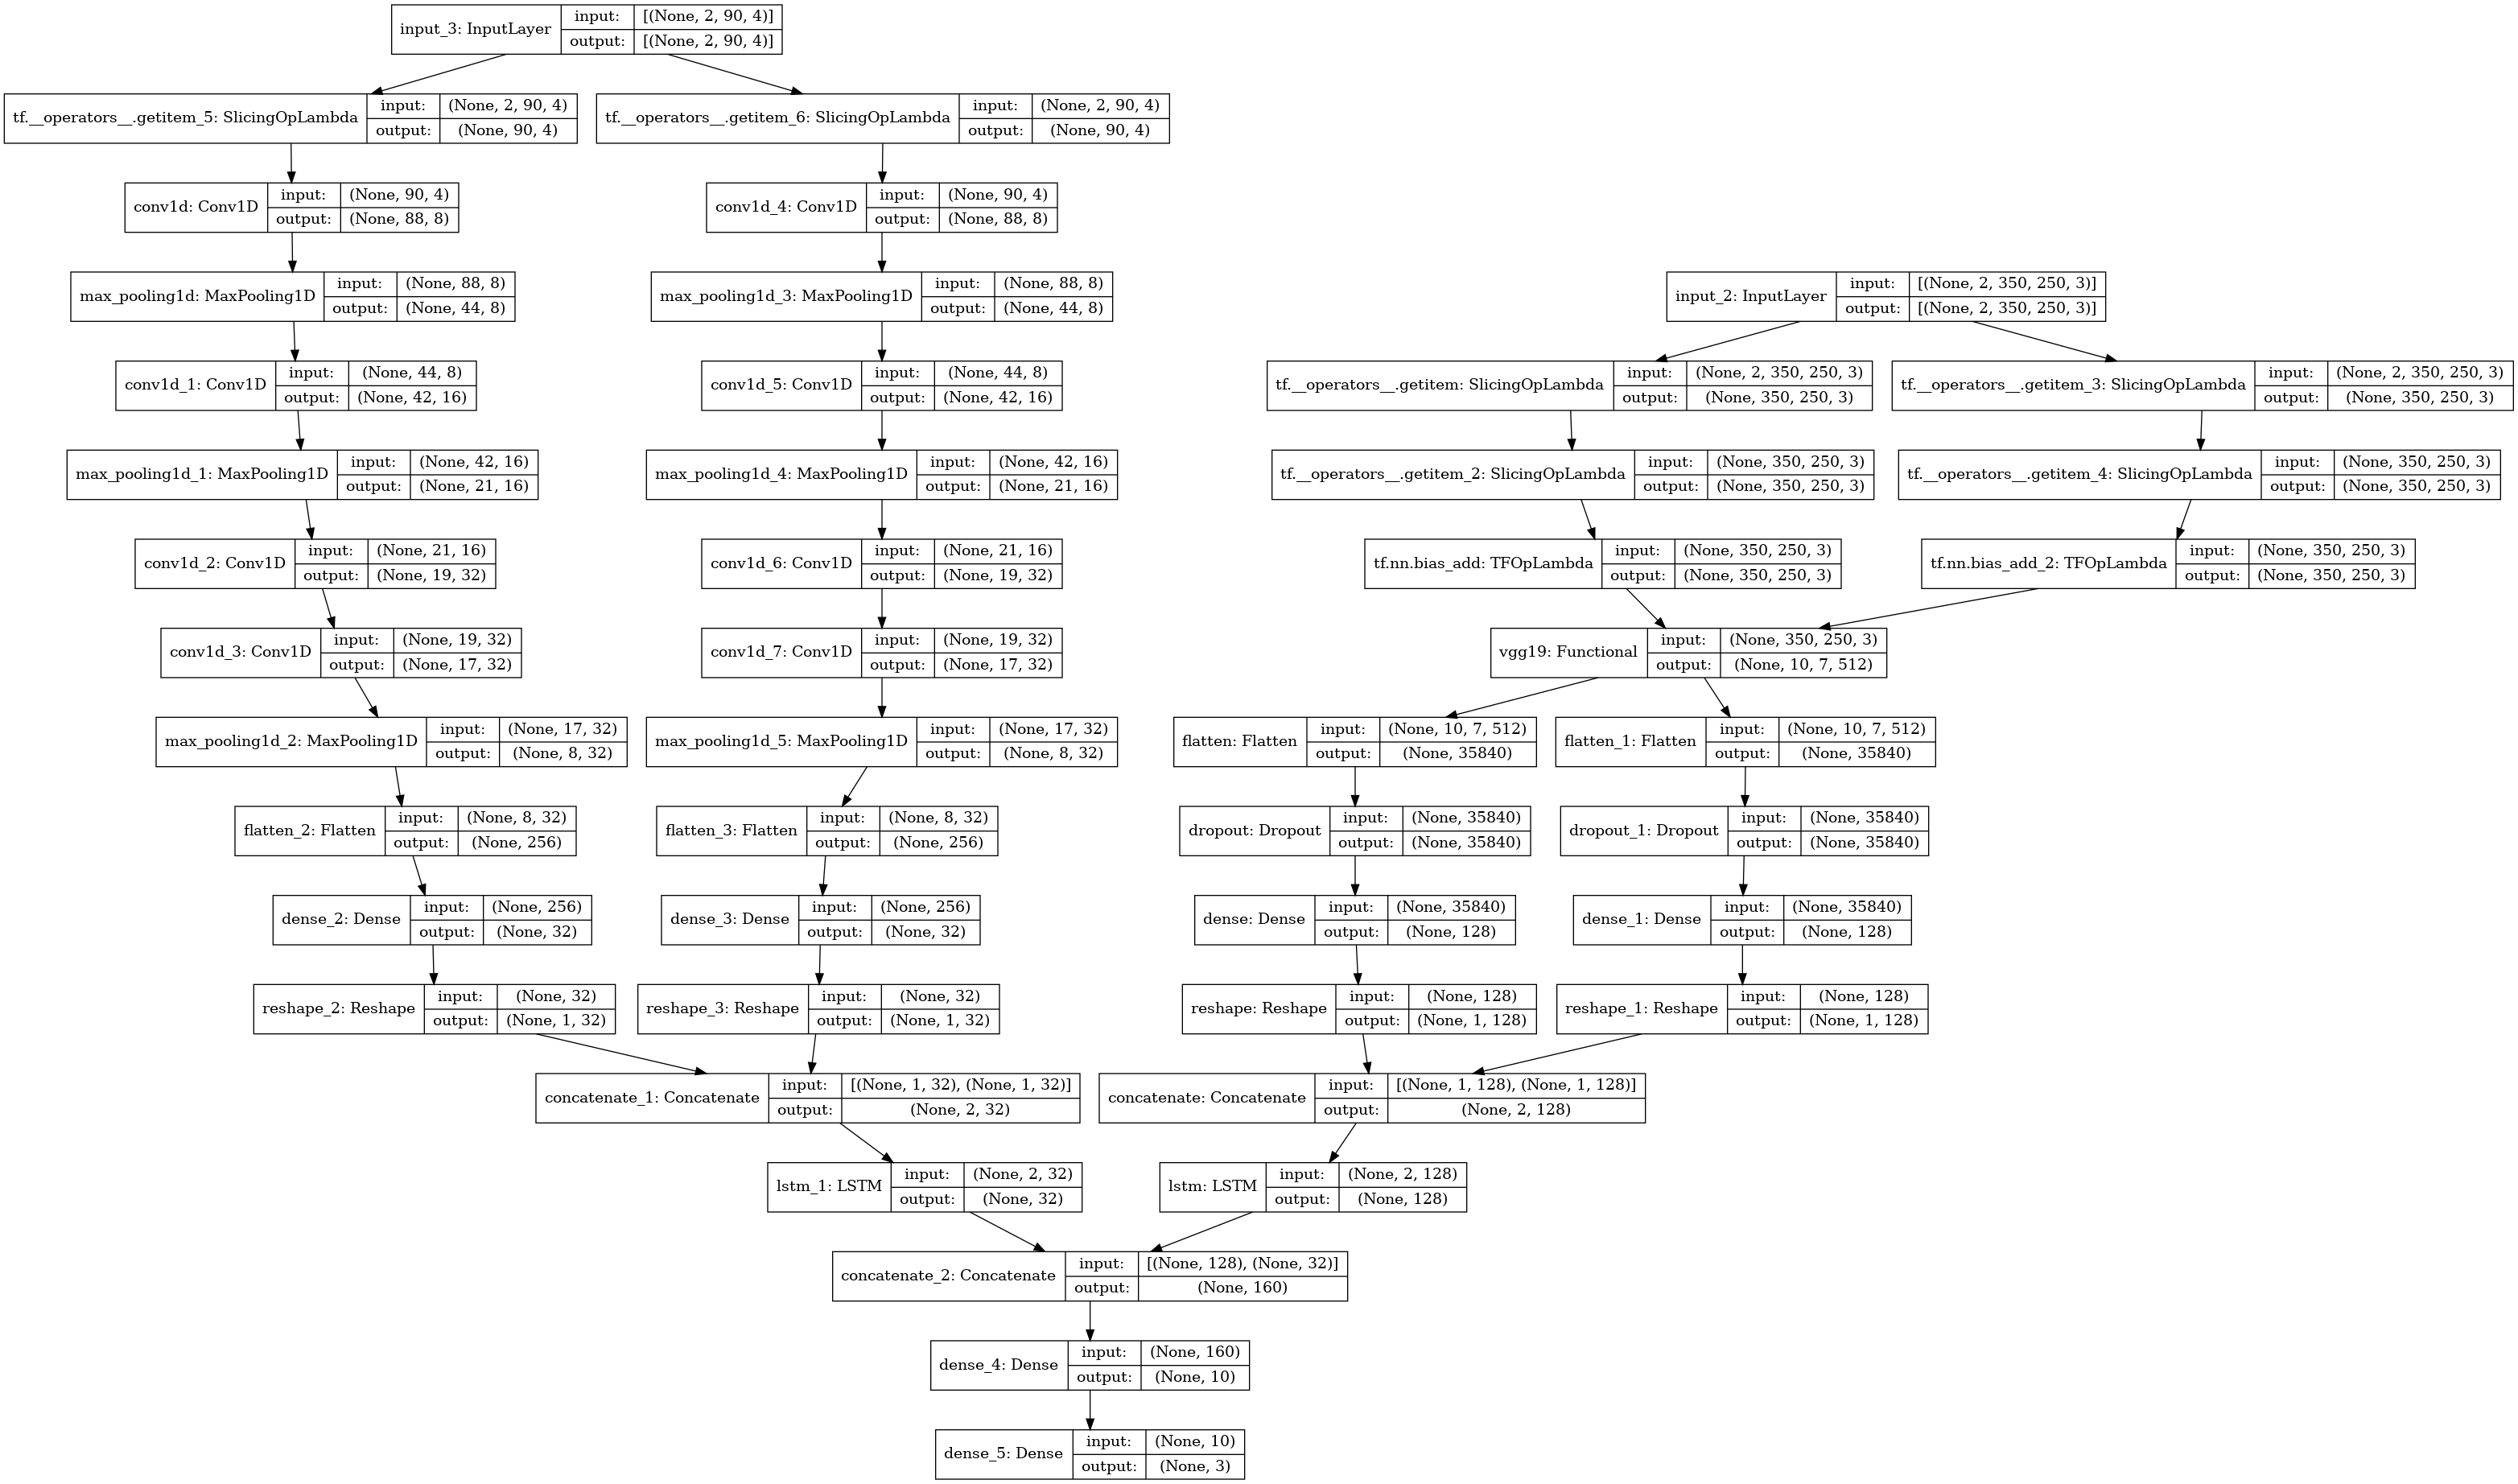

In [34]:
if not os.path.exists(public_dir_model):
    os.makedirs(public_dir_model)

plot_model(model, show_shapes=True, to_file=os.path.join(public_dir_model, 'model.png'))

## Define callback

In [35]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [36]:
callback_list_base = get_callback_list(monitor='val_loss', min_delta=0.01, patience=30, 
                                       factor=0.1, 
                                       checkpoint_dir=checkpoint_dir, HHMM=HHMM) # None None

callback_list = get_callback_list(monitor='val_loss', min_delta=0.01, patience=30, 
                                       factor=None, 
                                       checkpoint_dir=checkpoint_dir, HHMM=HHMM)

## Define class_weight

In [37]:
class_weight = get_class_weight(y_train)

for key, value in class_weight.items():
    print('Weight for class {}: {:.2f}'.format(key, value))

Weight for class 0: 2.66
Weight for class 1: 0.51
Weight for class 2: 1.55


## Training

In [38]:
history_base = model.fit(train_dataset,
                         validation_data=(valid_dataset),
                         epochs=200,
                         callbacks=callback_list_base,
                         class_weight=class_weight
                        )

Epoch 1/200
162/162 [==============================] - 135s 656ms/step - loss: 1.0353 - accuracy: 0.6520 - val_loss: 1.0147 - val_accuracy: 0.5156


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.001-1.01_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.001-1.01_1144/assets


Epoch 2/200
162/162 [==============================] - 32s 196ms/step - loss: 0.9112 - accuracy: 0.4840 - val_loss: 0.9476 - val_accuracy: 0.4506


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.002-0.95_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.002-0.95_1144/assets


Epoch 3/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8482 - accuracy: 0.4914 - val_loss: 0.9700 - val_accuracy: 0.4283


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.003-0.97_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.003-0.97_1144/assets


Epoch 4/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8404 - accuracy: 0.4707 - val_loss: 0.9789 - val_accuracy: 0.4310


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.004-0.98_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.004-0.98_1144/assets


Epoch 5/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8407 - accuracy: 0.4566 - val_loss: 0.9845 - val_accuracy: 0.4354


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.005-0.98_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.005-0.98_1144/assets


Epoch 6/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8357 - accuracy: 0.4614 - val_loss: 0.9862 - val_accuracy: 0.4328


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.006-0.99_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.006-0.99_1144/assets


Epoch 7/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8359 - accuracy: 0.4399 - val_loss: 0.9712 - val_accuracy: 0.4417


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.007-0.97_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.007-0.97_1144/assets


Epoch 8/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8311 - accuracy: 0.4662 - val_loss: 0.9763 - val_accuracy: 0.4435


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.008-0.98_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.008-0.98_1144/assets


Epoch 9/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8237 - accuracy: 0.4645 - val_loss: 0.9763 - val_accuracy: 0.4630


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.009-0.98_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.009-0.98_1144/assets


Epoch 10/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8239 - accuracy: 0.4775 - val_loss: 1.0165 - val_accuracy: 0.4248


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.010-1.02_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.010-1.02_1144/assets


Epoch 11/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8381 - accuracy: 0.4759 - val_loss: 0.9788 - val_accuracy: 0.4443


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.011-0.98_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.011-0.98_1144/assets


Epoch 12/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8192 - accuracy: 0.4648 - val_loss: 0.9701 - val_accuracy: 0.4550


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.012-0.97_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.012-0.97_1144/assets


Epoch 13/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8505 - accuracy: 0.4189 - val_loss: 0.9538 - val_accuracy: 0.4443


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.013-0.95_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.013-0.95_1144/assets


Epoch 14/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8741 - accuracy: 0.4030 - val_loss: 0.9469 - val_accuracy: 0.4479


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.014-0.95_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.014-0.95_1144/assets


Epoch 15/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8698 - accuracy: 0.4077 - val_loss: 0.9416 - val_accuracy: 0.4506


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.015-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.015-0.94_1144/assets


Epoch 16/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8691 - accuracy: 0.4083 - val_loss: 0.9388 - val_accuracy: 0.4497


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.016-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.016-0.94_1144/assets


Epoch 17/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8631 - accuracy: 0.4146 - val_loss: 0.9357 - val_accuracy: 0.4559


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.017-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.017-0.94_1144/assets


Epoch 18/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8649 - accuracy: 0.4095 - val_loss: 0.9347 - val_accuracy: 0.4550


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.018-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.018-0.93_1144/assets


Epoch 19/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8589 - accuracy: 0.4232 - val_loss: 0.9332 - val_accuracy: 0.4595


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.019-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.019-0.93_1144/assets


Epoch 20/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8609 - accuracy: 0.4193 - val_loss: 0.9331 - val_accuracy: 0.4559


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.020-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.020-0.93_1144/assets


Epoch 21/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8625 - accuracy: 0.4148 - val_loss: 0.9330 - val_accuracy: 0.4595


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.021-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.021-0.93_1144/assets


Epoch 22/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8595 - accuracy: 0.4141 - val_loss: 0.9335 - val_accuracy: 0.4604


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.022-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.022-0.93_1144/assets


Epoch 23/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8633 - accuracy: 0.4039 - val_loss: 0.9334 - val_accuracy: 0.4586


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.023-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.023-0.93_1144/assets


Epoch 24/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8560 - accuracy: 0.4151 - val_loss: 0.9338 - val_accuracy: 0.4586


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.024-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.024-0.93_1144/assets


Epoch 25/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8566 - accuracy: 0.4174 - val_loss: 0.9336 - val_accuracy: 0.4568


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.025-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.025-0.93_1144/assets


Epoch 26/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8602 - accuracy: 0.4221 - val_loss: 0.9331 - val_accuracy: 0.4595


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.026-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.026-0.93_1144/assets


Epoch 27/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8563 - accuracy: 0.4171 - val_loss: 0.9330 - val_accuracy: 0.4604


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.027-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.027-0.93_1144/assets


Epoch 28/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8617 - accuracy: 0.4101 - val_loss: 0.9345 - val_accuracy: 0.4550


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.028-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.028-0.93_1144/assets


Epoch 29/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8574 - accuracy: 0.4095 - val_loss: 0.9340 - val_accuracy: 0.4541


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.029-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.029-0.93_1144/assets


Epoch 30/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8561 - accuracy: 0.4177 - val_loss: 0.9347 - val_accuracy: 0.4568


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.030-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.030-0.93_1144/assets


Epoch 31/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8550 - accuracy: 0.4156 - val_loss: 0.9333 - val_accuracy: 0.4568


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.031-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.031-0.93_1144/assets


Epoch 32/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8719 - accuracy: 0.4014 - val_loss: 0.9339 - val_accuracy: 0.4604


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.032-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.032-0.93_1144/assets


Epoch 33/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8654 - accuracy: 0.3970 - val_loss: 0.9348 - val_accuracy: 0.4711


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.033-0.93_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.033-0.93_1144/assets


Epoch 34/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8598 - accuracy: 0.3961 - val_loss: 0.9356 - val_accuracy: 0.4800


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.034-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.034-0.94_1144/assets


Epoch 35/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8556 - accuracy: 0.4103 - val_loss: 0.9363 - val_accuracy: 0.4773


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.035-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.035-0.94_1144/assets


Epoch 36/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8496 - accuracy: 0.4146 - val_loss: 0.9369 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.036-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.036-0.94_1144/assets


Epoch 37/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8474 - accuracy: 0.4143 - val_loss: 0.9372 - val_accuracy: 0.4746


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.037-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.037-0.94_1144/assets


Epoch 38/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8474 - accuracy: 0.4146 - val_loss: 0.9373 - val_accuracy: 0.4764


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.038-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.038-0.94_1144/assets


Epoch 39/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8433 - accuracy: 0.4172 - val_loss: 0.9375 - val_accuracy: 0.4800


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.039-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.039-0.94_1144/assets


Epoch 40/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8453 - accuracy: 0.4149 - val_loss: 0.9376 - val_accuracy: 0.4800


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.040-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.040-0.94_1144/assets


Epoch 41/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8450 - accuracy: 0.4223 - val_loss: 0.9378 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.041-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.041-0.94_1144/assets


Epoch 42/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8415 - accuracy: 0.4159 - val_loss: 0.9378 - val_accuracy: 0.4791


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.042-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.042-0.94_1144/assets


Epoch 43/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8418 - accuracy: 0.4219 - val_loss: 0.9378 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.043-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.043-0.94_1144/assets


Epoch 44/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8437 - accuracy: 0.4179 - val_loss: 0.9378 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.044-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.044-0.94_1144/assets


Epoch 45/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8436 - accuracy: 0.4223 - val_loss: 0.9378 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.045-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.045-0.94_1144/assets


Epoch 46/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8424 - accuracy: 0.4212 - val_loss: 0.9379 - val_accuracy: 0.4791


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.046-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.046-0.94_1144/assets


Epoch 47/200
162/162 [==============================] - 32s 196ms/step - loss: 0.8442 - accuracy: 0.4214 - val_loss: 0.9379 - val_accuracy: 0.4791


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.047-0.94_1144/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model.047-0.94_1144/assets


### Save the model (before fine-tune)

In [39]:
model.save(os.path.join(checkpoint_dir, 'model_%s_base' % HHMM))

INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model_1144_base/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211203_gpu0/model_1144_base/assets


### History (before fine-tune)

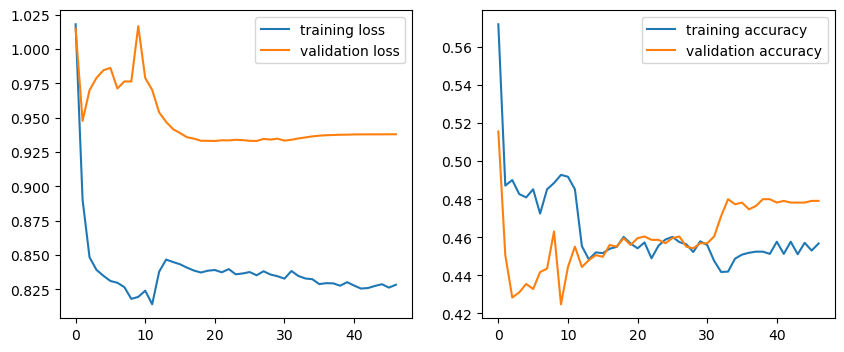

In [40]:
plot_history(history_base, n_class, to_file=os.path.join(public_dir_model, 'history.png'))

In [41]:
print_best_epoch(history_base, n_class)

min val_loss: 0.9330 ; Epoch 27

max val_accuracy: 0.5156 ; Epoch 1



## Fine-tune

In [ ]:
fine_tune(pretrain, trainable_layer='block5_conv1') # Unfreeze layers including and after block5_conv1

### Compile the model

In [ ]:
compile_model(model, n_class, lr=1e-5)

'''
You’ll do this with the Adam optimizer, using a very low learning rate. 
The reason for using a low learning rate is that
you want to limit the magnitude of the modifications you make to the representations
of the three layers you’re fine-tuning. Updates that are too large may harm these representations.
'''

###

In [ ]:
print('Number of trainable weights after unfreezing some pretrain layers:', len(model.trainable_weights))

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset,
                    validation_data=(valid_dataset),
                    epochs=200,
                    callbacks=callback_list,
                    class_weight=class_weight
                   )

### Save the model (after fine-tune)

In [ ]:
model.save(os.path.join(checkpoint_dir, 'model_%s' % HHMM))

### History (after fine-tune)

In [ ]:
plot_history(history, n_class, to_file=os.path.join(public_dir_model, 'history_tuned.png'))

In [ ]:
print_best_epoch(history, n_class)

###

In [42]:
end = datetime.now()

runtime = end - start

print('Start:', start)
print('End:', end)
print('Runtime:', runtime)

Start: 2021-12-03 11:44:17.398078
End: 2021-12-03 12:17:52.569835
Runtime: 0:33:35.171757


## Performance

In [43]:
y_valid_pred = model.predict(valid_dataset)
y_test_pred = model.predict(test_dataset)

In [44]:
y_valid_pred_label = get_pred_label(y_valid_pred, threshold=0.5)
y_test_pred_label = get_pred_label(y_test_pred, threshold=0.5)

In [45]:
y_valid_pred_class = get_str_class(y_valid_pred_label, n_class)
y_test_pred_class = get_str_class(y_test_pred_label, n_class)

### Validation

In [46]:
valid_result = get_result(y_valid_pred_class, y_valid, to_file=os.path.join(public_dir_model, 'valid_result.csv'))
valid_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.77,0.59,0.36,9,321,226
1,Normal,0.26,0.24,0.24,14,186,45
2,Small,0.81,0.69,0.29,100,200,22


### Test 

In [47]:
test_result = get_result(y_test_pred_class, y_test, to_file=os.path.join(public_dir_model, 'test_result.csv'))
test_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.75,0.55,0.39,6,295,250
1,Normal,0.31,0.26,0.28,19,215,57
2,Small,0.75,0.74,0.24,74,188,26


### Cold and Hot period (only on test set)

In [48]:
cold_pred, hot_pred, cold_true, hot_true = split_cold_hot(test_date, y_test_pred, y_test)

cold_pred_label = get_pred_label(cold_pred, threshold=0.5)
hot_pred_label = get_pred_label(hot_pred, threshold=0.5)

cold_pred_class = get_str_class(cold_pred_label, n_class)
hot_pred_class = get_str_class(hot_pred_label, n_class)

test_cold_result = get_result(cold_pred_class, cold_true, to_file=os.path.join(public_dir_model, 'test_result_cold.csv'))
test_hot_result = get_result(hot_pred_class, hot_true, to_file=os.path.join(public_dir_model, 'test_result_hot.csv'))

#### Cold (Nov-Apr)

In [49]:
test_cold_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.80,0.46,0.47,4,108,129
1,Normal,0.25,0.24,0.23,7,78,18
2,Small,0.83,0.72,0.26,55,129,15


#### Hot (May-Oct)

In [50]:
test_hot_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.71,0.61,0.34,2,187,121
1,Normal,0.36,0.27,0.32,12,137,39
2,Small,0.58,0.79,0.18,19,59,11


### ROC curve

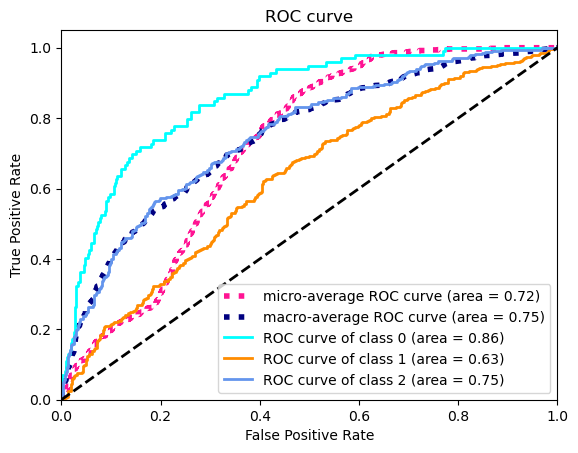

In [51]:
plot_roc_curve(y_test, y_test_pred, classes, lw=2, directory=public_dir_model) # can save to directory

### Precision-Recall curve

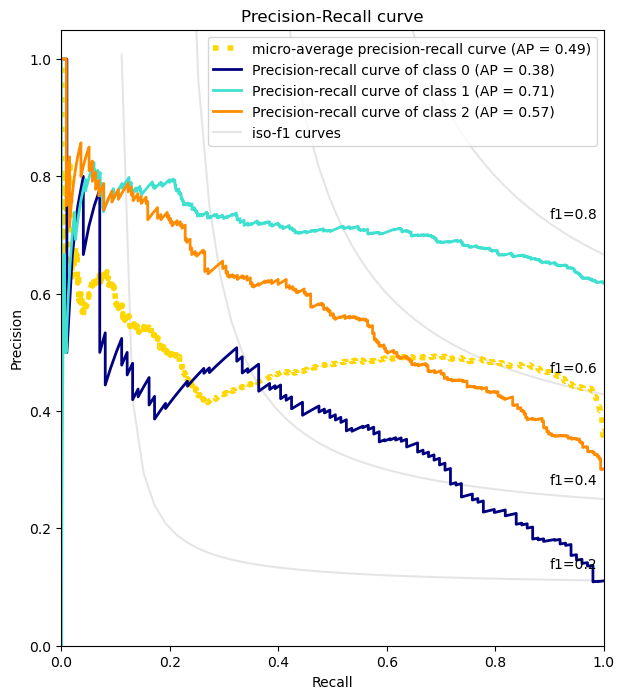

In [52]:
plot_pr_curve(y_test, y_test_pred, classes, lw=2, directory=public_dir_model) # can save to directory

### Classification report

In [53]:
print(classification_report(y_test, y_test_pred_label, target_names=None, output_dict=False))

              precision    recall  f1-score   support

           0       0.26      0.75      0.38        99
           1       0.74      0.31      0.43       698
           2       0.45      0.75      0.57       333

    accuracy                           0.48      1130
   macro avg       0.48      0.60      0.46      1130
weighted avg       0.61      0.48      0.47      1130



In [54]:
report = classification_report(y_test, y_test_pred_label, target_names=None, output_dict=True)

with open(os.path.join(public_dir_model, 'classification_report.json'), 'w') as fp:
    json.dump(report, fp, separators=(',', ':'), indent=0, ignore_nan=True)

### Review

In [55]:
df_review = get_review(y_test, y_test_pred, test_date, df_dv, verification=False, directory=public_dir_model) # can save to directory
df_review

,Date,Prob_0,Prob_1,Prob_2,Predicted DV class,Actual DV class,Actual DV,true_label,pred_label,confidence,abs_minTT,abs_maxTT,abs_DV,verification
0,2018080300,0.087371,0.456282,0.456347,Large,Normal,2.7,1,2,0.456347,29.1,31.8,2.7,False
1,2018080400,0.197451,0.485864,0.316685,Normal,Normal,5.2,1,1,0.485864,27.3,32.5,5.2,False
2,2018080500,0.040163,0.431403,0.528435,Large,Normal,4.2,1,2,0.528435,28.9,33.1,4.2,False
3,2018080600,0.035520,0.406893,0.557587,Large,Normal,5.0,1,2,0.557587,28.8,33.8,5.0,False
4,2018080700,0.008178,0.292650,0.699172,Large,Large,5.8,2,2,0.699172,28.4,34.2,5.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2021090400,0.024117,0.378294,0.597589,Large,Large,5.7,2,2,0.597589,27.9,33.6,5.7,False
1126,2021090500,0.042058,0.428670,0.529272,Large,Normal,4.9,1,2,0.529272,28.3,33.2,4.9,False
1127,2021090600,0.007372,0.303398,0.689230,Large,Normal,4.5,1,2,0.689230,28.0,32.5,4.5,False
1128,2021090700,0.050349,0.443596,0.506055,Large,Normal,5.3,1,2,0.506055,28.1,33.4,5.3,False


### Reliability diagram

Accuracy: 0.47699115044247786
Mean confidence: 0.57826716


/home/deeplearn/cslau/reliability_diagram.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


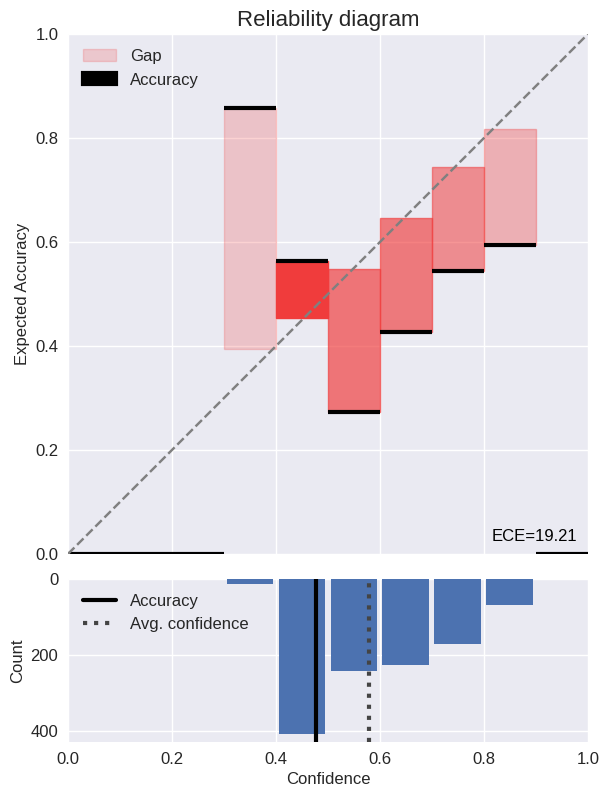

In [56]:
plot_reliability_diagram(df_review, num_bins=10, avg=True, 
                         classes=classes, start_UTC=None, lead_day=None, directory=public_dir_model) # can save to directory

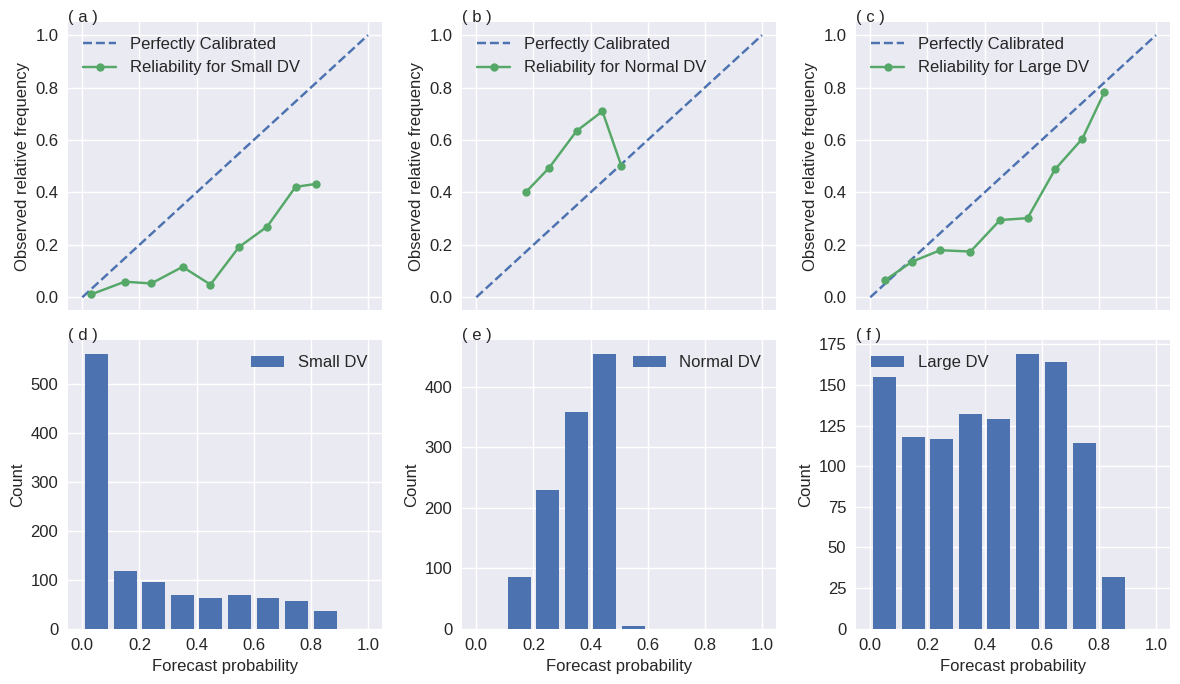

In [57]:
plot_reliability_diagram(df_review, num_bins=10, avg=False, 
                         classes=classes, start_UTC=None, lead_day=None, directory=public_dir_model) # can save to directory

In [58]:
mpl.rcParams.update(mpl.rcParamsDefault)

## Verification : ECMWF 137 tephi

In [59]:
df_dv = get_DV_df('/home/deeplearn/cslau/199101-202109_max_min_DV.csv', n_class)

In [60]:
df_9day_00, df_9day_12 = get_9day_result_(model, feature_to_scale, scaler, df_dv, 
                                          data, n_class, 
                                          public_dir_ec, ver_dir, 
                                          directory=public_dir_model)

In [61]:
df_9day_00

,day,class,POD,FAR,CSI,0,1,2
0,1,Large,0.68,0.36,0.49,1,36,66
1,1,Normal,0.48,0.28,0.40,5,61,19
2,1,Small,0.70,0.75,0.22,14,31,12
0,2,Large,0.67,0.37,0.48,1,37,64
1,2,Normal,0.39,0.36,0.32,6,51,23
2,2,Small,0.63,0.81,0.17,12,42,9
0,3,Large,0.66,0.38,0.47,2,37,63
1,3,Normal,0.43,0.35,0.35,4,55,25
2,3,Small,0.70,0.76,0.22,14,37,7
0,4,Large,0.63,0.43,0.42,3,43,60


### Plot comparison with CFO and OCF

In [62]:
def plot_result_comparison(df_model, df_cfo, df_ocf, utc='00', df_multi_model=None, multi_tephi=False, to_file=None):
    score = ['POD', 'FAR', 'CSI']
    classes = df_model['class'].unique()
    
    if utc == '00':
        x = np.arange(1, 10)
    elif utc == '12':
        if multi_tephi:
            x = np.arange(1, 9)
            df_model = df_model[df_model['day']<=8]
            df_cfo = df_cfo[df_cfo['day']<=8]
            df_ocf = df_ocf[df_ocf['day']<=8]
        else:
            x = np.arange(1, 10)
            
    if len(classes) == 3:
        fig, ax = plt.subplots(3, 3, sharex='col', figsize=(12, 8))
    elif len(classes) == 2:
        fig, ax = plt.subplots(3, 2, sharex='col', figsize=(8, 8))
    for i in range(len(score)):
        for j in range(len(classes)):
            ax[i][j].plot(x, df_model[df_model['class']==classes[j]][score[i]].values, '^-', label='Model')
            ax[i][j].plot(x, df_cfo[df_cfo['class']==classes[j]][score[i]].values, 'o-', label='CFO')
            ax[i][j].plot(x, df_ocf[df_ocf['class']==classes[j]][score[i]].values, 'o-', label='OCF')
            if df_multi_model is not None:
                ax[i][j].plot(x, df_multi_model[df_multi_model['class']==classes[j]][score[i]].values, 's-', label='New model')
            ax[i][j].set_ylim(0, 1)
            ax[i][j].set_xticks(x)
            ax[i][j].set_xticklabels([str(n) for n in x])
            ax[i][j].set_title(classes[j], fontsize=14)
            if i == 2:
                ax[i][j].set_xlabel('Forecast day', fontsize=15)
            if j == 0:
                ax[i][j].set_ylabel(score[i], fontsize=15)
                
            ax[i][j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #ax[i][j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                            #fancybox=True, shadow=True, ncol=3)
                       
    plt.tight_layout()
    
    if to_file is not None:
        fig.savefig(to_file, bbox_inches="tight", pad_inches=0.2)

In [63]:
public_dir_model

'/home/deeplearn/public_html/20211203_gpu0_model_1144'

In [64]:
n_class

3

In [65]:
if n_class == 3:
    df_cfo = pd.read_csv('./cfo_9day_performance')
    df_ocf = pd.read_csv('./ocf_dv.csv')
elif n_class == 2:
    df_cfo = pd.read_csv('./cfo_9day_performance_binary')
    df_ocf = pd.read_csv('./ocf_binary_12Z.csv')

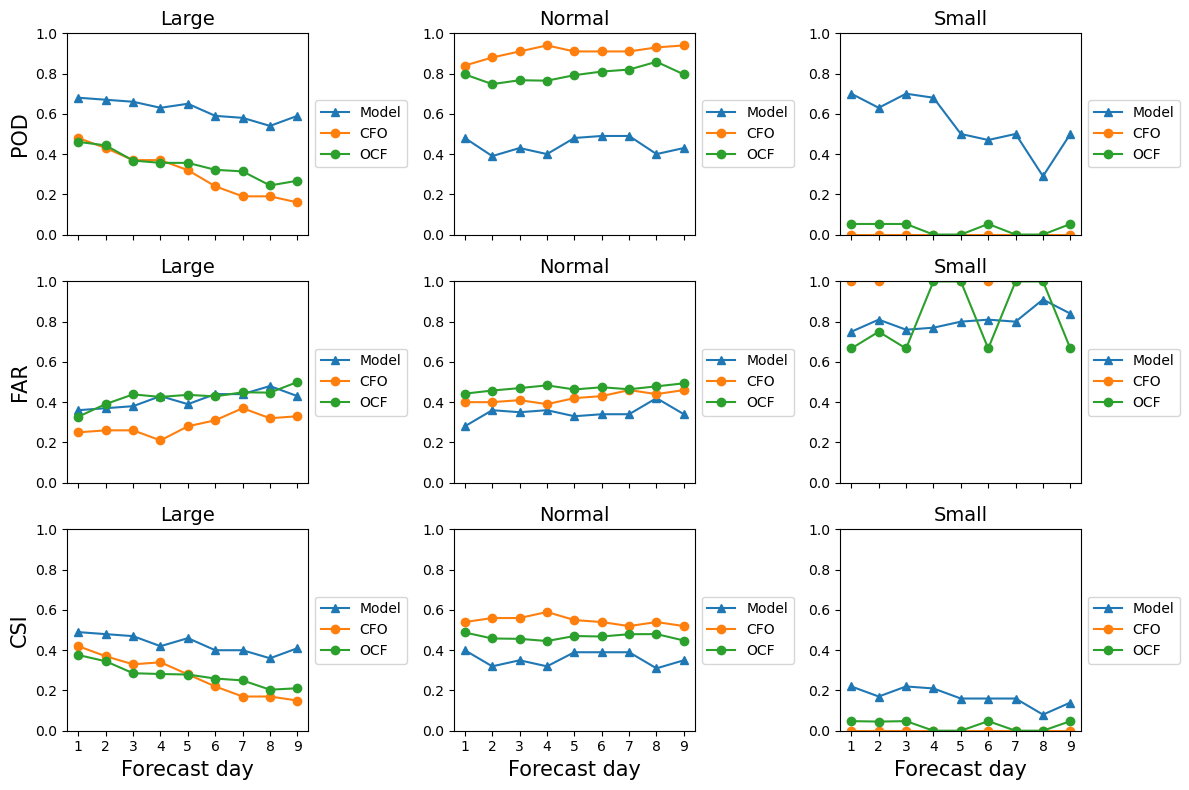

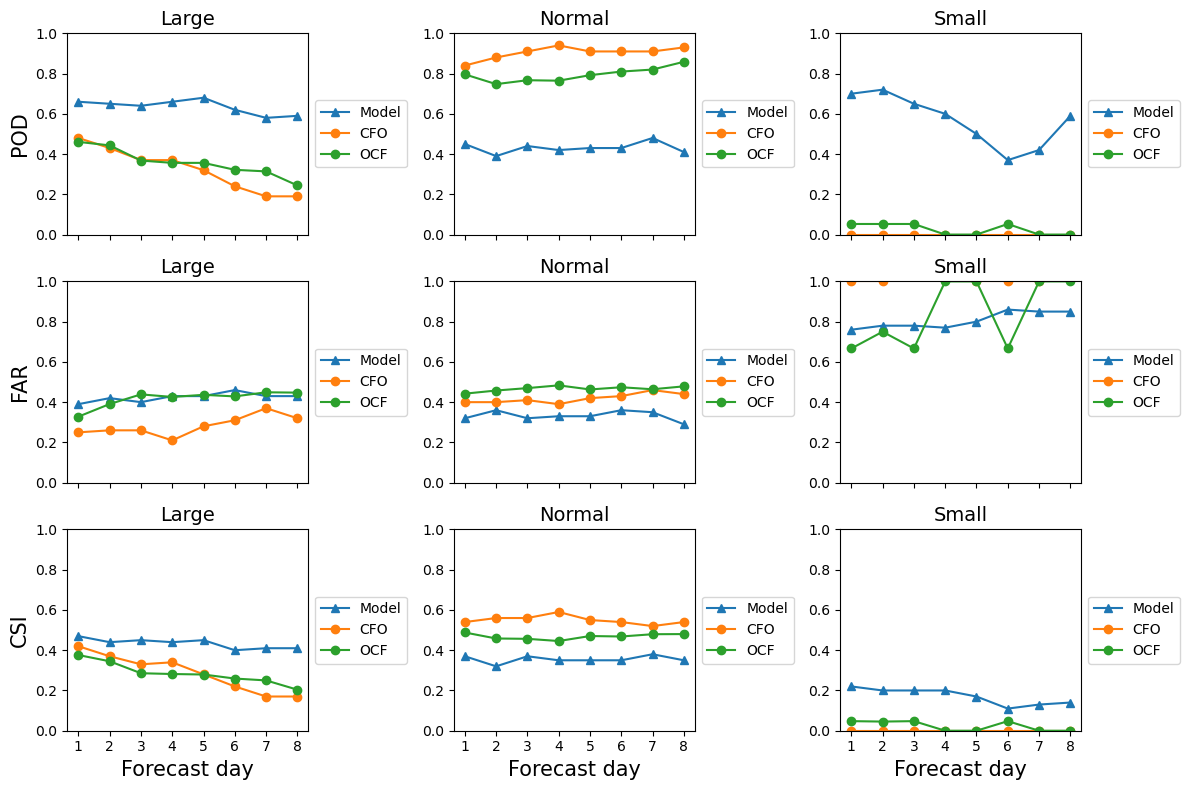

In [66]:
for utc in ['00', '12']:
    df_model = pd.read_csv(public_dir_model + '/model_9day_result_%sZ.csv' % utc)
    plot_result_comparison(df_model, df_cfo, df_ocf, utc, multi_tephi=True, to_file=os.path.join(public_dir_model, 'result_comparison_%sZ.png' % utc))
    plt.show()
    plt.close()

### Get 00Z day1 review to csv

In [ ]:
ec_dataset, model_run, forecast = get_ec_dataset('00', 1, feature_to_scale, scaler, 
                                                 df_dv, data, public_dir_ec, ver_dir)

In [ ]:
ec_pred = model.predict(ec_dataset)

In [ ]:
y_true = df_dv[df_dv['date'].apply(lambda x: x in forecast)]['dv_class']

In [ ]:
df_review_ec = get_review(y_true, ec_pred, forecast, df_dv, verification=True, directory=public_dir_model) # can save to directory

###